In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()

In [4]:
lonMin = (float)(config['REGEION']['LON_MIN'])
lonMax = (float)(config['REGEION']['LON_MAX'])

latMin = (float)(config['REGEION']['LAT_MIN'])
latMax = (float)(config['REGEION']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['HOURLY_HEATMAP']['INCR_STEP'])
incrRes = (int)(config['HOURLY_HEATMAP']['INCR_RES'])

-120.0 31.0
-117.0 34.5


In [5]:
xGrid = np.arange(lonMin,lonMax,increStep)
xGrid = np.around(xGrid,incrRes)
yGrid = np.arange(latMin,latMax,increStep)
yGrid = np.around(yGrid,incrRes)

In [6]:
heatMapDirectory = "../Data/AIS_0117_1217_31_M120_345_M117/HourlyHM/"

heatMapData = []
for i in range(0,2160):
    heatMapFile = heatMapDirectory + str(i) + '.npy'
    heatMapVal = np.load(heatMapFile)
    heatMapData.append(heatMapVal)

In [8]:
nonZeroBlocks = [447, 507, 686, 706, 742, 743, 767, 768, 796, 797, 798, 855, 856, 994]
print(nonZeroBlocks)

[447, 507, 686, 706, 742, 743, 767, 768, 796, 797, 798, 855, 856, 994]


In [9]:
def generate_region_data(index, bW):
    #histogram data
    histData = []
    histLabel = []

    #get the row and column of the desired grid
    indexRow, indexCol = hMUtil.get_row_col(index, yGrid.shape[0], xGrid.shape[0])
    
    width = xGrid.shape[0]
    height = yGrid.shape[0]
    
    #now iterate through heatmap files
    for hM in heatMapData:
        #copy the data file
        tempNP = hM.copy()
        
        #reshape it in 2D fashion
        #so that we can levarege the window
        tempNP = np.reshape(tempNP,(yGrid.shape[0],xGrid.shape[0]))
        
        #now slice the array 
        #here it has to be window
        #the regeion we are interested
        #and some cells which are near to this regeion
        leftRow = indexRow-bW
        if(leftRow < 0):
            leftRow = 0
            
        rightRow = indexRow+bW+1
        if(rightRow > height): 
            rightRow = height
            
        leftCol = (indexCol-bW)
        if(leftCol < 0):
            leftCol = 0
            
        rightCol = (indexCol+bW+1)
        if(rightCol > width): 
            rightCol = width
        
            
        histNPX = tempNP[(leftRow):(rightRow),leftCol:rightCol].copy()

        #now append this into the list
        histData.append(histNPX.flatten())

        #after that we have our own regeion
        histNPY = tempNP[indexRow,indexCol].copy()
        
        #we need to add things up for label
        histY = np.sum(histNPY)
        #append that into label
        histLabel.append(histY)
        
    histLabelNP = np.asarray(histLabel)
    return np.asarray(histData),histLabelNP

#will make a data set for time series forcast
#will consider how many previous data we want to consider
#will also take the feature matrix 
#and output feature
#will return matrix of reduced dimension
#which can be used as a feature factor
def make_time_series_data(matX,matY,pastFeatures,futureFeature = 0):
    #first make data set for time series regression
    #so based on past features to consider
    #we will have data set limited by that number
    noRowsX = matX.shape[0] - pastFeatures - futureFeature

    #initialise m*n dimensional array for X(where n is number of past features)
    #where m is total number data points for the training and testing
    #m will be noRowsX
    retXMat = np.zeros(shape=(noRowsX,(pastFeatures*matX.shape[1])))
        
    #initialise noRowsX*column dimensional array for Y
    retYMat = np.zeros(shape=(noRowsX))
    
                       
    for i in range(0,noRowsX):
        #numpy array with zero element
        temp = np.zeros(0)
        
        for j in range(i,i+pastFeatures):
            temp = np.append(temp,matX[j])
        retXMat[i] = temp
        retYMat[i] = matY[i+pastFeatures+futureFeature]
    return retXMat,retYMat,noRowsX

In [14]:
trainScoreMat = np.zeros((7,8))
testScoreMat = np.zeros((7,8))

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

#bandwidth iteration
for bWI in range(1,8):
    for prevTime in range(1,9):
        dataX, dataY = generate_region_data(686,bWI)
        dataXTS,dataYTS,noOfSamples = make_time_series_data(dataX,dataY,prevTime)
        #add bias term
        biasTerm = np.ones(shape = (dataXTS.shape[0],1))
        print(biasTerm.shape)
        featureMat = np.hstack((biasTerm,dataXTS))
        print(featureMat.shape)

        dataXTrain,dataXTest,dataYTrain,dataYTest = train_test_split(featureMat\
                                                                     ,dataYTS\
                                                                     ,train_size = 0.8\
                                                                     ,test_size = 0.2\
                                                                     ,shuffle = False\
                                                                    )

        #to normalise the data
        scaler = preprocessing.StandardScaler().fit(dataXTrain)
        dataXTrainNorm = scaler.transform(dataXTrain)

        cS = [0.0001,0.001, 0.01, 0.1, 1, 10]
        gammas = [0.0001,0.001, 0.01, 0.1, 1]
        epsiolons = [0.0001,0.001, 0.01, 0.1, 1]

        paramGrid = {'C': cS, 'gamma' : gammas, 'epsilon' : epsiolons}

        gridSearch = GridSearchCV(svm.SVR(kernel='rbf'), paramGrid, n_jobs = -1)
        gridSearch.fit(dataXTrainNorm, dataYTrain)

        sVR = gridSearch.best_estimator_
        sVR.fit(dataXTrainNorm, dataYTrain.flatten())

        #lets see whats the score
        #we will return it to plot the matrix
        trainScore = sVR.score(dataXTrainNorm,dataYTrain)
        print(trainScore)

        dataXTestNorm = scaler.transform(dataXTest)

        testScore = sVR.score(dataXTestNorm,dataYTest)
        print(testScore)
        trainScoreMat[bWI-1,prevTime-1] = trainScore
        testScoreMat[bWI-1,prevTime-1] = testScore
        

22 26
(2159, 1)
(2159, 10)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7455458187313035
0.5687040004710411
22 26
(2158, 1)
(2158, 19)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.760358488489278
0.5469851810699224
22 26
(2157, 1)
(2157, 28)
0.7744510002186449
0.5526056940623607
22 26
(2156, 1)
(2156, 37)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7790372440385384
0.5667038664600411
22 26
(2155, 1)
(2155, 46)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7893021629598433
0.5777518059748687
22 26
(2154, 1)
(2154, 55)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7969983103348056
0.590457211961399
22 26
(2153, 1)
(2153, 64)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8010838201494584
0.588555775754062
22 26
(2152, 1)
(2152, 73)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8030983029379359
0.5847415927783628
22 26
(2159, 1)
(2159, 26)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7292577621965954
0.5155216687545893
22 26
(2158, 1)
(2158, 51)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7761292030278281
0.5618088063820935
22 26
(2157, 1)
(2157, 76)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8003641998940665
0.5698402419910668
22 26
(2156, 1)
(2156, 101)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8167754316815343
0.589366273962324
22 26
(2155, 1)
(2155, 126)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8320146408688812
0.589938055386286
22 26
(2154, 1)
(2154, 151)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8452597850977176
0.5828339033293967
22 26
(2153, 1)
(2153, 176)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8381862071454855
0.5756397715519662
22 26
(2152, 1)
(2152, 201)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8427387762707781
0.5777003078834626
22 26
(2159, 1)
(2159, 50)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7439745156264157
0.4812519792914829
22 26
(2158, 1)
(2158, 99)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7558395929444577
0.4824476196074531
22 26
(2157, 1)
(2157, 148)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8388048468622612
0.5468630596068861
22 26
(2156, 1)
(2156, 197)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8436434551095701
0.5352750295713538
22 26
(2155, 1)
(2155, 246)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8663087369208071
0.5152143516869208
22 26
(2154, 1)
(2154, 295)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8845494851014473
0.49415084175086177
22 26
(2153, 1)
(2153, 344)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.896517847759863
0.4846741475022709
22 26
(2152, 1)
(2152, 393)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7836863023682834
0.5175375369016559
22 26
(2159, 1)
(2159, 73)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7559073279795503
0.48253442289622106
22 26
(2158, 1)
(2158, 145)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.821717758132681
0.5234064220581602
22 26
(2157, 1)
(2157, 217)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8620959868204638
0.541129999700406
22 26
(2156, 1)
(2156, 289)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7750256864808287
0.5032390108149942
22 26
(2155, 1)
(2155, 361)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7840549368559897
0.5138461632770195
22 26
(2154, 1)
(2154, 433)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7931300724172904
0.5205040576518858
22 26
(2153, 1)
(2153, 505)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7973377925019386
0.5223753321009812
22 26
(2152, 1)
(2152, 577)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8030830822813473
0.5300390758786542
22 26
(2159, 1)
(2159, 100)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7758098087317918
0.5019946686999126
22 26
(2158, 1)
(2158, 199)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7546859434168505
0.4818131285080679
22 26
(2157, 1)
(2157, 298)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7727748802252599
0.4836845484779334
22 26
(2156, 1)
(2156, 397)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7890718745168466
0.5109831427778153
22 26
(2155, 1)
(2155, 496)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8022741673660096
0.5326494109471973
22 26
(2154, 1)
(2154, 595)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8154452792560034
0.5473151423762384
22 26
(2153, 1)
(2153, 694)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8247012902268054
0.55217064433207
22 26
(2152, 1)
(2152, 793)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8309082702569349
0.5515881138721005
22 26
(2159, 1)
(2159, 131)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8026727853578445
0.5294390388029423
22 26
(2158, 1)
(2158, 261)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7631377555298543
0.4956375670081352
22 26
(2157, 1)
(2157, 391)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7883508037025881
0.5045466785541464
22 26
(2156, 1)
(2156, 521)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8075658485487913
0.5362182553345864
22 26
(2155, 1)
(2155, 651)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8221677439340175
0.5534157463501352
22 26
(2154, 1)
(2154, 781)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8378879362071784
0.5680088040424749
22 26
(2153, 1)
(2153, 911)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8508073729159943
0.5627204074791652
22 26
(2152, 1)
(2152, 1041)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8589599187417909
0.5553175532492469
22 26
(2159, 1)
(2159, 166)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8291868084605434
0.553862425236737
22 26
(2158, 1)
(2158, 331)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7643851761859742
0.49867556059963414
22 26
(2157, 1)
(2157, 496)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8017863253964557
0.5207120631942475
22 26
(2156, 1)
(2156, 661)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8220399629877567
0.5351604326246953
22 26
(2155, 1)
(2155, 826)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8402722623027787
0.5507760284121371
22 26
(2154, 1)
(2154, 991)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8572613201464312
0.551852731489409
22 26
(2153, 1)
(2153, 1156)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8753379413906685
0.5243142568727885
22 26
(2152, 1)
(2152, 1321)


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8897760657003654
0.5097907374954211


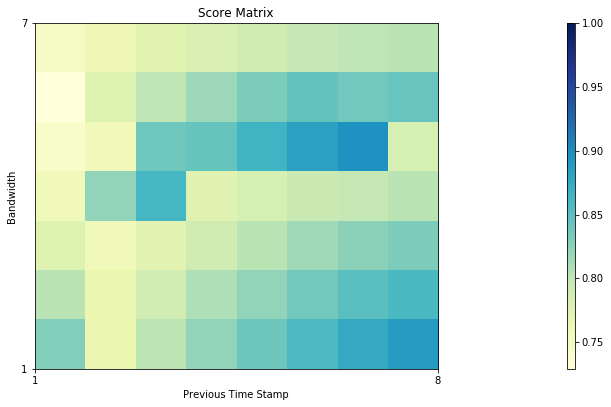

In [19]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 6

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.10, 0.11, 0.80, 0.80])
ax3 = fig.add_axes([0.96, 0.11, 0.01, 0.80])

ax1.set_xticks([1,8])
ax1.set_yticks([1,7])

titleStr = "Score Matrix"
ax1.set_title(titleStr)
ax1.set_xlabel('Previous Time Stamp')
ax1.set_ylabel('Bandwidth')

hMHandler = ax1.imshow(trainScoreMat, cmap=plt.get_cmap('YlGnBu'), extent=[1,8,1,7], vmax = 1)
fig.colorbar(hMHandler,ax3)